In [1]:
#global imports
import os
import sys
import pandas as pd
import numpy as np
from IPython.display import display
pd.options.display.max_columns = None

In [2]:
#local imports
sys.path.append('/Users/yangzhang/document/ds_projs')  
from myfunctions import WhosMissing, DisplayRMSEcvScores, rmse_cv, PlotLearningCurve

In [3]:
DATA_PATH = os.path.join('data')

In [4]:
def load_training_data(training_path=DATA_PATH):
    cvs_path = os.path.join(training_path, 'train.csv')
    return pd.read_csv(cvs_path)

In [5]:
def load_predicting_data(predicting_path=DATA_PATH):
    cvs_path = os.path.join(predicting_path, 'test.csv')
    return pd.read_csv(cvs_path)

In [6]:
train_preview = load_training_data()

In [7]:
WhosMissing(train_preview)

This data set has 19 features with missing values.


[None,
               Total   Percent
 PoolQC         1453  0.995205
 MiscFeature    1406  0.963014
 Alley          1369  0.937671
 Fence          1179  0.807534
 FireplaceQu     690  0.472603
 LotFrontage     259  0.177397
 GarageCond       81  0.055479
 GarageType       81  0.055479
 GarageYrBlt      81  0.055479
 GarageFinish     81  0.055479
 GarageQual       81  0.055479
 BsmtExposure     38  0.026027
 BsmtFinType2     38  0.026027
 BsmtFinType1     37  0.025342
 BsmtCond         37  0.025342
 BsmtQual         37  0.025342
 MasVnrArea        8  0.005479
 MasVnrType        8  0.005479
 Electrical        1  0.000685]

In [8]:
test_preview = load_predicting_data()

In [9]:
WhosMissing(test_preview)

This data set has 33 features with missing values.


[None,
               Total   Percent
 PoolQC         1456  0.997944
 MiscFeature    1408  0.965045
 Alley          1352  0.926662
 Fence          1169  0.801234
 FireplaceQu     730  0.500343
 LotFrontage     227  0.155586
 GarageCond       78  0.053461
 GarageQual       78  0.053461
 GarageYrBlt      78  0.053461
 GarageFinish     78  0.053461
 GarageType       76  0.052090
 BsmtCond         45  0.030843
 BsmtQual         44  0.030158
 BsmtExposure     44  0.030158
 BsmtFinType1     42  0.028787
 BsmtFinType2     42  0.028787
 MasVnrType       16  0.010966
 MasVnrArea       15  0.010281
 MSZoning          4  0.002742
 BsmtHalfBath      2  0.001371
 Utilities         2  0.001371
 Functional        2  0.001371
 BsmtFullBath      2  0.001371
 BsmtFinSF2        1  0.000685
 BsmtFinSF1        1  0.000685
 Exterior2nd       1  0.000685
 BsmtUnfSF         1  0.000685
 TotalBsmtSF       1  0.000685
 SaleType          1  0.000685
 Exterior1st       1  0.000685
 KitchenQual       1  0.000685
 

# Prepare data for ML

## Feature Imputation

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin#, RegressorMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder#, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline#, FeatureUnion
from scipy.stats import skew
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.feature_extraction.text import _VectorizerMixin
from sklearn.feature_selection._base import SelectorMixin

In [8]:
class FeatureImputer(BaseEstimator, TransformerMixin):
    """
    This class fills in missing values for both test and train data sets.
    """
    def __init__(self, fill_missvals=True):
        self.fill_missvals = fill_missvals
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.fill_missvals:
            X['PoolQC'] = X['PoolQC'].fillna('None')
            X['MiscFeature'] = X['MiscFeature'].fillna('None')
            X['Alley'] = X['Alley'].fillna('None')
            X['Fence'] = X['Fence'].fillna('None')
            X['FireplaceQu'] = X['FireplaceQu'].fillna('None')
            X['LotFrontage'] = X.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
            for col in ('GarageCond', 'GarageType', 'GarageFinish', 'GarageQual', 'BsmtExposure', 'GarageYrBlt',
                        'BsmtFinType1', 'BsmtFinType2', 'BsmtCond', 'BsmtQual', 'MasVnrType'):
                X[col] = X[col].fillna('None')   
            X['Electrical'] = X['Electrical'].fillna(X['Electrical'].mode()[0])
            
            X['MSZoning'] = X['MSZoning'].fillna(X['MSZoning'].mode()[0])
            X['SaleType'] = X['SaleType'].fillna(X['SaleType'].mode()[0])
            X['KitchenQual'] = X['KitchenQual'].fillna(X['KitchenQual'].mode()[0])
            X['Exterior1st'] = X['Exterior1st'].fillna(X[X['HouseStyle'] == '1Story'].Exterior1st.mode()[0])
            X['Exterior2nd'] = X['Exterior2nd'].fillna(X[X['HouseStyle'] == '1Story'].Exterior2nd.mode()[0])
            X['Utilities'] = X['Utilities'].fillna(X[X['HouseStyle'] == '1Story'].Utilities.mode()[0])
            X['GarageCars'] = X['GarageCars'].fillna(X[X['GarageType'] == 'Detchd'].GarageCars.mode()[0])
            X['GarageArea'] = X['GarageArea'].fillna(X[X['GarageType'] == 'Detchd'].GarageArea.mean())
            X["Functional"] = X["Functional"].fillna("Typ")
            
            for col in ('MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
                X[col] = X[col].fillna(0)

            #X['GarageYrBlt'] = X['GarageYrBlt'].astype(str)
            X['MSSubClass'] = X['MSSubClass'].astype(str)   
                   
        return X

In [9]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Add a few new features.
    """
    def __init__(self, additional=1):
        self.additional = additional
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.additional == 1:
            X['HouseAge'] = X['YrSold'] - X['YearBuilt']
            X['BathperRoom'] = (X['FullBath'] + X['HalfBath']*2) / X['TotRmsAbvGrd']
            X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
            X['TotalArea'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF'] + X['GarageArea']
            X['TotalPorch'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['3SsnPorch'] + X['ScreenPorch']
        else:
            X['HouseAge'] = X['YrSold'] - X['YearBuilt']
            X['BathperRoom'] = (X['FullBath'] + X['HalfBath']*2) / X['TotRmsAbvGrd']
            X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
            X['TotalArea'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF'] + X['GarageArea']
            X['TotalPorch'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['3SsnPorch'] + X['ScreenPorch']
        
        return X     

In [10]:
class DropCols(BaseEstimator, TransformerMixin):
    def __init__(self, remove_cols=True):
        self.remove_cols = remove_cols
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.remove_cols:
            del X['MoSold']
            del X['GarageYrBlt']
            del X['YearBuilt']
            del X['YearRemodAdd']
            del X['YrSold']
            del X['PoolQC']
            del X['MiscFeature']
            del X['Exterior1st']
            del X['GarageFinish']     
            del X['RoofStyle']
            del X['3SsnPorch']
            del X['Street']
            #del X['Condition1']
            #del X['Condition2']
            del X['LotConfig']
            del X['PoolArea']
            del X['ExterCond']
            del X['SaleType']
            del X['Exterior2nd']
            del X['LowQualFinSF']
            del X['BldgType']
            del X['Electrical']
            del X['BsmtFinType1']
            del X['BsmtFinType2']
            del X['Alley']
        return X

In [70]:
train_preview.select_dtypes(include='object').columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [124]:
train_preview.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Numerical transformer

In [11]:
class NumericTransformer(BaseEstimator, TransformerMixin):
    """
    This takes care of the skewness.
    """
    def __init__(self, skew=0.75):
        self.skew = skew
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        #X['MSSubClass'] = X['MSSubClass'].apply(str)
        numerical_attribs = X.select_dtypes(exclude='object').columns
        X_numeric = X[numerical_attribs]
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features]+0.001)
        #X[skewness_features] = X.skewness_features.apply(lambda x: np.log1p(x) if x > 0 else x)
        #X = pd.get_dummies(X)
        
        return X

In [12]:
num_transformer = Pipeline([
    ('imputer', NumericTransformer(skew=0.5))
])

## Categorical transformer

In [13]:
# One-hot encode categorical values
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=None)),
    ('onehot', OneHotEncoder(handle_unknown='error'))])

In [14]:
## put together
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, selector(dtype_exclude='object')),
        ('cat', cat_transformer, selector(dtype_include='object'))])

In [15]:
#credit: https://stackoverflow.com/questions/57528350/can-you-consistently-keep-track-of-column-labels-using-sklearns-transformer-api

def get_feature_out(estimator, feature_in):
    if hasattr(estimator,'get_feature_names'):
        if isinstance(estimator, _VectorizerMixin):
            # handling all vectorizers
            return [f'vec_{f}' \
                for f in estimator.get_feature_names()]
        else:
            return estimator.get_feature_names(feature_in)
    elif isinstance(estimator, SelectorMixin):
        return np.array(feature_in)[estimator.get_support()]
    else:
        return feature_in

def get_ct_feature_names(ct):
    # handles all estimators, pipelines inside ColumnTransfomer
    # doesn't work when remainder =='passthrough'
    # which requires the input column names.
    output_features = []

    for name, estimator, features in ct.transformers_:
        if name!='remainder':
            if isinstance(estimator, Pipeline):
                current_features = features
                for step in estimator:
                    current_features = get_feature_out(step, current_features)
                features_out = current_features
            else:
                features_out = get_feature_out(estimator, features)
            output_features.extend(features_out)
        elif estimator=='passthrough':
            output_features.extend(ct._feature_names_in[features])
                
    return output_features

## Complete pipeline

In [16]:
preprocessing = Pipeline([
    ('missing_val', FeatureImputer()),
    ('new_features', FeatureEngineer()),
    ('drop_cols', DropCols()),
    ('preprocessor', preprocessor),
])

In [131]:
from sklearn import set_config
set_config(display='diagram')
preprocessing

Pipeline(steps=[('missing_val', FeatureImputer()),
                ('new_features', FeatureEngineer()), ('drop_cols', DropCols()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   NumericTransformer(skew=0.5))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9390a2c250>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f93d63bf130>)]))])

# Model training

## getting data ready

In [17]:
train_preview = load_training_data()
train_preview['MSSubClass'] = train_preview['MSSubClass'].apply(str)
train_X = train_preview.drop(['Id', 'SalePrice'], axis=1)
train_X.shape

(1460, 79)

In [18]:
train_y = train_preview['SalePrice']
train_y_norm = np.log1p(train_y)

In [19]:
train_X_ready = preprocessing.fit_transform(train_X)

In [20]:
train_X_ready = pd.DataFrame(train_X_ready.toarray(),
             columns=get_ct_feature_names(preprocessor))

In [21]:
train_X_ready.shape

(1460, 215)

# Base models

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

## Regression

### linear regression

In [27]:
from sklearn.linear_model import LinearRegression

In [30]:
lin_reg = LinearRegression()
lin_reg.fit(train_X_ready, train_y)

LinearRegression()

In [31]:
predictions = lin_reg.predict(train_X_ready)
lin_mse = mean_squared_error(train_y, predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

22272.446569214684

In [32]:
DisplayRMSEcvScores(lin_reg, train_X_ready, train_y)

Scores: [23093.92833503 27426.07662566 26572.02299466 39740.72427584
 34794.29179169 37928.07760555 26944.76253068 25173.53797053
 51390.82777728 25355.93277065]
Mean: 31842.018
Standard deviation: 8512.491


### Decision tree

In [33]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(train_X_ready, train_y)

predictions = tree_reg.predict(train_X_ready)
tree_mse = mean_squared_error(train_y, predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

157.29955716699112

In [34]:
DisplayRMSEcvScores(tree_reg, train_X_ready, train_y)

Scores: [33231.2827692  39387.19799117 41664.90535194 41509.96281073
 38634.10910968 36727.26386627 33528.37431447 34918.69861775
 38343.64527979 33716.41937137]
Mean: 37166.186
Standard deviation: 3056.842


### Random forests

In [28]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(train_X_ready, train_y)

predictions = forest_reg.predict(train_X_ready)
forest_mse = mean_squared_error(train_y, predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

10464.703962149577

In [36]:
DisplayRMSEcvScores(forest_reg, train_X_ready, train_y)

Scores: [25179.74866118 26040.51175743 28011.97782722 40089.56834439
 33903.42183528 24312.48941562 23715.07059688 23094.08030875
 37364.87746328 24020.05254211]
Mean: 28573.180
Standard deviation: 5908.329


In [45]:
## save model result
import joblib

joblib.dump(lin_reg, './models/base_LR.pkl')
joblib.dump(tree_reg, './models/base_DT.pkl')
joblib.dump(forest_reg, './models/base_RF.pkl')

['./models/base_RF.pkl']

## Fine-tune

### Grid Search

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
forest_reg = RandomForestRegressor()

In [31]:
param_grid = [
    {'bootstrap': [False], 'n_estimators': [260, 270, 290, 300, 330], 'max_features': [50, 60, 70, 80]},
]

In [32]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

In [35]:
grid_search.fit(train_X_ready2, train_y_norm)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid=[{'bootstrap': [False],
                          'max_features': [50, 60, 70, 80],
                          'n_estimators': [260, 270, 290, 300, 330]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [192]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 70, 'n_estimators': 330}

In [36]:
cvres = grid_search.cv_results_

In [194]:
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.13279517687663997 {'bootstrap': False, 'max_features': 50, 'n_estimators': 260}
0.13366288838295484 {'bootstrap': False, 'max_features': 50, 'n_estimators': 270}
0.13277879827254155 {'bootstrap': False, 'max_features': 50, 'n_estimators': 290}
0.13285446133414205 {'bootstrap': False, 'max_features': 50, 'n_estimators': 300}
0.13302835814224453 {'bootstrap': False, 'max_features': 50, 'n_estimators': 330}
0.1328551218407177 {'bootstrap': False, 'max_features': 60, 'n_estimators': 260}
0.1326372221307573 {'bootstrap': False, 'max_features': 60, 'n_estimators': 270}
0.13254718662911408 {'bootstrap': False, 'max_features': 60, 'n_estimators': 290}
0.13289818728485536 {'bootstrap': False, 'max_features': 60, 'n_estimators': 300}
0.1329252401421532 {'bootstrap': False, 'max_features': 60, 'n_estimators': 330}
0.13241649931502103 {'bootstrap': False, 'max_features': 70, 'n_estimators': 260}
0.13282615259265587 {'bootstrap': False, 'max_features': 70, 'n_estimators': 270}
0.13292099474656824

In [37]:
tuned_RF = grid_search.best_estimator_

<module 'matplotlib.pyplot' from '/Users/yangzhang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

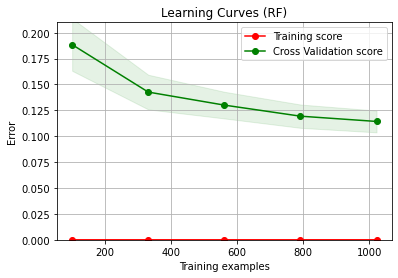

In [38]:
from sklearn.model_selection import ShuffleSplit
title = 'Learning Curves (RF)'
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
PlotLearningCurve(tuned_RF, title, train_X_ready2, train_y_norm, ylim=(0, 0.21), cv=cv)

In [40]:
import matplotlib.pyplot as plt
plt.savefig('./figures/learningcurve.png', dpi=100)

<Figure size 432x288 with 0 Axes>

In [386]:
feature_importance = grid_search.best_estimator_.feature_importances_

In [387]:
attributes = train_X_ready3.columns

In [32]:
#sorted(zip(feature_importance, attributes), reverse=True)  ##should you remove unimportant features?

In [165]:
test_preview = load_predicting_data()

In [185]:
test_preview['MSSubClass'] = test_preview['MSSubClass'].apply(str)
test = test_preview.drop(['Id'], axis=1)
test_id = test_preview['Id']

In [186]:
test_ready = preprocessing.fit_transform(test)

In [187]:
test_ready = pd.DataFrame(test_ready.toarray(),
             columns=get_ct_feature_names(preprocessor))

In [188]:
test_ready = test_ready.drop(['MSSubClass_150'], axis=1)

In [199]:
test_ready.shape

(1459, 203)

In [198]:
train_X_ready2.shape

(1460, 203)

In [34]:
train_X_ready2 = train_X_ready.drop(['HouseStyle_2.5Fin', 'Condition2_RRAe', 'RoofMatl_Roll', 'RoofMatl_Metal', 'GarageQual_Ex',
                                     'Condition2_RRNn', 'Heating_Floor', 'RoofMatl_Membran', 'RoofMatl_ClyTile', 'Condition2_RRAn',
                                     'Utilities_NoSeWa', 'Heating_OthW'], axis=1)

In [177]:
list(set(train_X_ready2.columns)-set(test_ready.columns))

[]

In [201]:
final_predictions = tuned_RF.predict(test_ready)

In [202]:
final_predictions2 = np.expm1(final_predictions)

In [203]:
submission = {'Id': test_id, 'SalePrice': final_predictions2}
submission = pd.DataFrame(data=submission)
#submission.to_csv('./submission/tunedRF.csv', index=False)

In [204]:
q1 = submission['SalePrice'].quantile(0.0042)
q2 = submission['SalePrice'].quantile(0.99)
# Quantiles helping us get some extreme values for extremely low or high values 
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

In [205]:
submission.to_csv('./submission/tunedRF5.csv', index=False)

### XGBoost

In [206]:
from xgboost.sklearn import XGBRegressor
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                       max_depth=3, min_child_weight=0,
                       gamma=0, subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror', nthread=-1,
                       scale_pos_weight=1, seed=27, reg_alpha=0.00006)

In [207]:
xgboost.fit(train_X_ready2, train_y_norm)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=0, missing=nan, monotone_constraints='()',
             n_estimators=3460, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             random_state=27, reg_alpha=6e-05, reg_lambda=1, scale_pos_weight=1,
             seed=27, subsample=0.7, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [209]:
final_predictions = xgboost.predict(test_ready)
final_predictions = np.expm1(final_predictions)
submission = {'Id': test_id, 'SalePrice': final_predictions}
submission = pd.DataFrame(data=submission)

q1 = submission['SalePrice'].quantile(0.0042)
q2 = submission['SalePrice'].quantile(0.99)
# Quantiles helping us get some extreme values for extremely low or high values 
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv('./submission/XGBoost.csv', index=False)

### Lasso regression

In [85]:
from sklearn.linear_model import Lasso

In [86]:
llr = Lasso(alpha=130, fit_intercept=True, max_iter=10000, normalize=False, positive=False, precompute=False, random_state=None)

In [245]:
llr.fit(train_X_ready3, train_y)

Lasso(alpha=130, max_iter=10000)

In [246]:
DisplayRMSEcvScores(llr, train_X_ready3, train_y)

Scores: [20334.07648195 24096.11154376 24390.37735122 36277.97707943
 34998.74512647 29245.25799262 26098.66603792 24108.71366307
 47055.46157948 24641.72487717]
Mean: 29124.711
Standard deviation: 7658.917


In [151]:
FI_lasso = pd.DataFrame({'Feature Importance': llr.coef_},
                       index=train_X_ready3.columns)

In [247]:
import matplotlib.pyplot as plt
%matplotlib inline

#FI_lasso[FI_lasso['Feature Importance'] != 0].sort_values('Feature Importance').plot(kind='barh', figsize=(10,55))
#plt.xticks(rotation=90)
#plt.ylabel
#plt.show

In [155]:
train_X_ready3.shape

(1460, 283)

In [156]:
test_ready3.shape

(1459, 283)

### SVR

In [41]:
from sklearn.svm import SVR

In [248]:
model = SVR(C=2, cache_size=200, coef0=0.1, degree=3, epsilon=0.005, gamma=0.005,
           kernel='rbf', max_iter=-1, shrinking=True, tol=0.01, verbose=False)

In [249]:
DisplayRMSEcvScores(model, train_X_ready3, train_y_norm)

Scores: [0.20461745 0.19754537 0.18989918 0.2148844  0.24126232 0.18618783
 0.21221282 0.19950556 0.20153333 0.20156117]
Mean: 0.205
Standard deviation: 0.015


In [159]:
model.fit(train_X_ready3, train_y_norm)
final_predictions = model.predict(test_ready3)
final_predictions = np.expm1(final_predictions)
submission = {'Id': test_id, 'SalePrice': final_predictions}
submission = pd.DataFrame(data=submission)

In [160]:
#q1 = submission['SalePrice'].quantile(0.0042)
#q2 = submission['SalePrice'].quantile(0.99)
# Quantiles helping us get some extreme values for extremely low or high values 
#submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
#submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv('./submission/svr.csv', index=False)

In [60]:

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

In [61]:
def PlotLearningCurve(estimator, title, X, y, ylim=None, cv=None,
                     n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Error')
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = 1-np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = 1-np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross Validation score')
    
    plt.legend(loc='best')
    return plt

## Correlation matrix

In [100]:
forcorr = pd.concat([view, y], axis=1)
corr_matrix = forcorr.corr()
pd.options.display.max_rows = 2000
with open('corr.txt', 'w') as f:
    print(corr_matrix['SalePrice'].sort_values(ascending=False), 'corr.txt', file=f)

In [ ]:
scaler = RobustScaler()

In [ ]:
dfFinal = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

In [ ]:
dfFinal.head()

In [ ]:
# define cross validation 
from sklearn.model_selection import cross_val_score, StratifiedKFold
def rmse_cv(model,X,y):
    scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=10)
    #the MSE scores returned is always negative
    rmse = np.sqrt(-scores) 
    return rmse # the higher the better

In [ ]:
#HYPERPARAMS NOT optimized
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR

models = [LinearRegression(),
          Ridge(),
          Lasso(),
          ElasticNet(),
          BayesianRidge(),
          SGDRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          SVR(),
          KernelRidge(),
          ExtraTreesRegressor()]
names = ["Linear Rregression", "Ridge", "Lasso", "Elastic Net", "Bayesian Ridge", "SGD",
         "RF", "GBR", "SVR", "Ker","Extra"]